In [22]:
# Instalación de dependencias
!pip install torch torchvision torchaudio
!pip install opencv-python-headless
!pip install easyocr
!pip install yolov5

In [23]:
# Montar Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
# Importar librerías necesarias
import torch #Biblioteca para trabajar con modelos de aprendizaje profundo
import cv2 # Biblioteca para procesamiento de imágenes y video
import time # Para medir tiempos de ejecución
import re # Biblioteca para trabajar con expresiones regulares
import numpy as np # Biblioteca para cálculos numéricos
import easyocr # Biblioteca OCR para reconocimiento de texto
import os # Biblioteca para manejo de archivos y directorios
from IPython.display import Image, display # Para mostrar imágenes en Jupyter Notebook
import yolov5 # Biblioteca YOLOv5 para detección de objetos

In [25]:
EASY_OCR = easyocr.Reader(['en']) # Inicializar EasyOCR para idioma inglés
OCR_TH = 0.2 # Umbral de confianza para el OCR

# Cargar modelos
vehicle_model = torch.hub.load('ultralytics/yolov5', 'yolov5s') # Modelo YOLOv5 para detección de vehículos
plate_model = yolov5.load('keremberke/yolov5m-license-plate') # Modelo YOLOv5 para detección de placas

# Función para realizar detecciones con un modelo YOLOv5
def detectx(frame, model):
    #Args: frame(Imagen en la que se realizarán las detecciones), model(Modelo YOLOv5 a utilizar)
    results = model(frame)
    return results.xyxy[0]  # Devuelve las detecciones en formato xyxy (coordenadas del cuadro delimitador)

# Función para filtrar el texto detectado en una placa, eliminando caracteres no alfanuméricos
def filter_plate_text(plate_text): #plate_text: Texto detectado por OCR
    #Args: plate_text(Texto detectado por OCR)
    if isinstance(plate_text, list):  # Comprobar si plate_text es una lista
        plate_text = ''.join(plate_text)  # Unir elementos de la lista en una sola cadena
    # Usar una expresión regular para mantener solo letras y números
    return re.sub(r'[^A-Za-z0-9]', '', plate_text)  # Texto filtrado con solo letras y números

# Función para dibujar cuadros delimitadores y mostrar resultados
def plot_boxes(frame, vehicle_detections, plate_detections):
    #Args: frame(Imagen original), vehicle_detections(Detecciones de vehículos), plate_detections(Detecciones de placas)
    vehicle_classes = ['car', 'truck', 'motorcycle'] # Clases de vehículos a considerar
    vehicle_info = [] # Lista para almacenar información sobre vehículos detectados

    # Procesar detecciones de vehículos
    for detection in vehicle_detections:
        x1, y1, x2, y2, conf, cls = detection # Extraer datos de la detección
        # Obtener tipo del vehículo detectado
        if conf >= 0.55 and vehicle_model.names[int(cls)] in vehicle_classes:
            vehicle_type = vehicle_model.names[int(cls)]
            # Dibujar rectángulo azul
            cv2.rectangle(frame, (int(x1), int(y1)), (int(x2), int(y2)), (255, 0, 0), 2)
            # Escribir tipo del vehículo sobre el rectángulo
            cv2.putText(frame, f"{vehicle_type}", (int(x1), int(y1)-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,0), 2)
            #Almacenar el tipo del vehículo detectado, la confianza del modelo en la detección del vehículo y las coordenadas del cuadro delimitador
            vehicle_info.append({"type": vehicle_type, "confidence": conf, "x1": x1, "x2": x2, "y1": y1, "y2": y2})

    # Procesar detecciones de placas
    for detection in plate_detections:
        x1, y1, x2, y2, conf, cls = detection # Extraer datos de la detección
        if conf >= 0.55: # Filtrar por confianza mínima de la detección de la placa
            coords = [int(x1), int(y1), int(x2), int(y2)] # Coordenadas del cuadro delimitador
            #Detectar el texto en la placa
            plate_num = recognize_plate_easyocr(img=frame, coords=coords, reader=EASY_OCR, region_threshold=OCR_TH)

            # Filtrar el texto de la placa
            plate_num = filter_plate_text(plate_num)

            cv2.rectangle(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
            cv2.putText(frame, f"Placa: {plate_num}", (int(x1), int(y1)-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 2)

            if vehicle_info:
                nearest_vehicle = min(vehicle_info, key=lambda v: abs((v['x1']+v['x2'])/2 - (x1+x2)/2))
                print(f"Tipo de vehículo: {nearest_vehicle['type']}, Placa: {plate_num}, Confianza: {conf:.2f}")
            else:
                print(f"Placa detectada: {plate_num}, Confianza: {conf:.2f}, pero no se asoció a ningún vehículo")

    return frame

# Función para reconocer texto en una región específica usando EasyOCR (Reconocer la matrícula. )
def recognize_plate_easyocr(img, coords, reader, region_threshold):
    #Args: img(Imagen original), coords(Coordenadas del cuadro delimitador), reader(Objeto EasyOCR), region_threshold(Umbral mínimo para considerar una región válida)
    xmin, ymin, xmax, ymax = coords
    nplate = img[int(ymin):int(ymax), int(xmin):int(xmax)] ## Recortar la región correspondiente a la placa
    ocr_result = reader.readtext(nplate) ## Realizar OCR en la región recortada
    text = filter_text(region=nplate, ocr_result=ocr_result, region_threshold=region_threshold)
    if len(text) == 1:
        text = text[0].upper()
    return text #Texto reconocido en la región

# Función para filtrar texto basado en el tamaño de la región
def filter_text(region, ocr_result, region_threshold):
    #Args: region(Imagen de la región de la placa), ocr_result(Resultado del OCR), region_threshold(Umbral para filtrar regiones de texto por tamaño)
    rectangle_size = region.shape[0]*region.shape[1] #Calcula el área total de la región de la placa
    plate = [] #lista vacía para almacenar el texto filtrado
    print(ocr_result) # Imprime el resultado del OCR para depuración
    for result in ocr_result: # Itera sobre cada resultado del OCR
        length = np.sum(np.subtract(result[0][1], result[0][0])) #Calcula la longitud del texto detectado
        height = np.sum(np.subtract(result[0][2], result[0][1])) #Calcula la altura del texto detectado
        if length*height / rectangle_size > region_threshold: #Comprueba si el área del texto es mayor que el umbral proporcional
            plate.append(result[1]) # Si supera el umbral, añade el texto a la lista
    return plate #Lista de textos filtrados que superan el umbral de tamaño.

# Función principal para procesar imágenes o videos
def main(img_path=None):
    #Args: img_path(Ruta de la imagen a procesar)
    print(f"[INFO] Loading models... ") #Imprime un mensaje indicando que se están cargando los modelos

    # Definir la carpeta de salida
    output_folder = "/content/drive/My Drive/PROYECTO/SALIDA"
    os.makedirs(output_folder, exist_ok=True) # Crea la carpeta de salida si no existe

    if img_path is not None: # Comprueba si se ha proporcionado una ruta de imagen
        print(f"[INFO] Working with image: {img_path}") # Imprime un mensaje indicando el procesamiento de imagen
        img_out_name = os.path.join(output_folder, f"result_{os.path.basename(img_path)}") # Genera el nombre del archivo de salida

        frame = cv2.imread(img_path) # Lee la imagen
        # Convertir la imagen de BGR a RGB(Asegurar la compatibilidad entre las diferentes partes del pipeline de procesamiento de imágenes)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        vehicle_results = detectx(frame, model=vehicle_model) #Realiza la detección de vehículo
        plate_results = detectx(frame, model=plate_model) #Realiza la detección de placas

        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR) #Convierte la imagen de vuelta a BGR para guardarla
        frame = plot_boxes(frame, vehicle_results, plate_results) #Dibuja las cajas y etiquetas en la imagen

        cv2.imwrite(img_out_name, frame) #Guarda la imagen resultante
        print(f"[INFO] Image saved as {img_out_name}")
        display(Image(filename=img_out_name)) #Muestra la imagen en Jupyter Notebook

    else:
        print("Error: Debe proporcionar una ruta de imagen.")

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2025-2-20 Python-3.11.11 torch-2.5.1+cu124 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


[INFO] Loading models... 
[INFO] Working with image: /content/drive/MyDrive/PROYECTO/ENTRADAS/1.jpg


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/usr/local/lib/python3.11/dist-packages/yolov5/models/common.py:709: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


[([[17, 5], [118, 5], [118, 43], [17, 43]], '6872 K', 0.5261036142451162)]
Placa detectada: 6872K, Confianza: 0.85, pero no se asoció a ningún vehículo
[INFO] Image saved as /content/drive/My Drive/PROYECTO/SALIDA/result_1.jpg


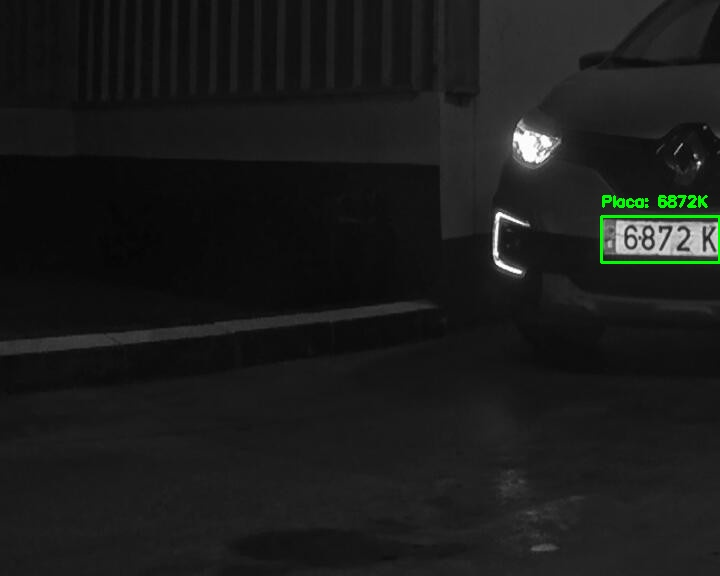

In [26]:
main(img_path="/content/drive/MyDrive/PROYECTO/ENTRADAS/1.jpg")

In [27]:
# Directorio que contiene las imágenes
image_directory = '/content/drive/My Drive/PROYECTO/ENTRADAS'

# Obtener una lista de todas las imágenes en el directorio
image_files = [f for f in os.listdir(image_directory) if f.endswith(('.jpg', '.jpeg', '.png'))]

# Procesar cada imagen
for image_file in image_files:
    image_path = os.path.join(image_directory, image_file)
    print(f"Procesando: {image_file}")
    main(image_path)


Output hidden; open in https://colab.research.google.com to view.